# Minimise Cost with Tariff
This notebook minimises the cost for the house by shifting the load throughout the day
The load is simulated by taking the average duration is runs annually, and the rated power

There are 4 different tariffs that can be applied.


## Select a house
| HouseID   |   Load        |
|---------  |   ------      |
|64613      |   hot_water   |
|70210      |   pool        |
|70243      |   hot_water   |
|70277      |   hot_water   |
|91912      |   pool        |
|91910      |   hot_water   |

In [1]:
from os import path
from os import getcwd, listdir
path_to_data = path.join('..', 'data', 'houses')
houses = listdir(path_to_data)
for h in houses: print(path.splitext(h)[0])

64613
69914
70177
70210
70243
70277
91341
91910
91911
91912
97245


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thesisInitial.cleaning_data import extract_data_from_house, \
    extract_rated_power, extract_average_time_on, apply_new_load, generate_load
import seaborn as sns
import thesisInitial.tariff as tf
import time

sns.set()
house_id = 70210
load_type = 'pool'

### Importing Data and cleaning up

In [3]:
data = extract_data_from_house(house_id, load_type)
rated_power = extract_rated_power(data.load)
average_duration = extract_average_time_on(data.load)
data.head()
idx = pd.date_range(start='2019-01-01 00:00:00', end='2019-12-31 23:55:00', freq='5T')
data = data.reindex(idx, fill_value=0)

### Tariff Choices
There are 4 Tariff Categories Currently
<li> flat
<li> Time of Use (TOU)
<li> Flat with controlled Load
<li> TOU with controlled load

In [4]:
tariff_type = 'TOU'
tariffs = tf.read_tariffs()

tariff = None
for t in tariffs:
    if t.tariff_type == tariff_type:
        tariff = t

print("Tariff Name: " + tariff.tariff_name)


Tariff Name: OriginGo


In [5]:
data['import_cost'] = tariff.get_cost(data['2019'][['grid_import', 'load']] / 1000)
data['export_revenue'] = (data['2019'].grid_export / 1000) * tariff.get_fit()
print('Import Cost' + " ${:.2f}".format(data.import_cost.sum() / 100))
print("Export Revenue" " ${:.2f}".format(data.export_revenue.sum() / 100))
print("Net Cost" + " ${:.2f}".format(data.import_cost.sum() / 100 - data.export_revenue.sum() / 100))

Import Cost $2361.44
Export Revenue $176.07
Net Cost $2185.38


#### Preload Possible Load Times Using Average Duration and Rated Power

In [6]:
# Date Range to Minimise Cost
date_range = '2019-11'

from thesisInitial.possible_load import ExtractLoad
possible_load = ExtractLoad(data[date_range].load)

2019-11-04 00:00:00
2019-11-04 00:05:00
2019-11-04 00:10:00
2019-11-04 00:15:00
2019-11-04 00:20:00
2019-11-04 00:25:00
2019-11-04 00:30:00
2019-11-04 00:35:00
2019-11-04 00:40:00
2019-11-04 00:45:00
2019-11-04 00:50:00
2019-11-04 00:55:00
2019-11-04 01:00:00
2019-11-04 01:05:00
2019-11-04 01:10:00
2019-11-04 01:15:00
2019-11-04 01:20:00
2019-11-04 01:25:00
2019-11-04 01:30:00
2019-11-04 01:35:00
2019-11-04 01:40:00
2019-11-04 01:45:00
2019-11-04 01:50:00
2019-11-04 01:55:00
2019-11-04 02:00:00
2019-11-04 02:05:00
2019-11-04 02:10:00
2019-11-04 02:15:00
2019-11-04 02:20:00
2019-11-04 02:25:00
2019-11-04 02:30:00
2019-11-04 02:35:00
2019-11-04 02:40:00
2019-11-04 02:45:00
2019-11-04 02:50:00
2019-11-04 02:55:00
2019-11-04 03:00:00
2019-11-04 03:05:00
2019-11-04 03:10:00
2019-11-04 03:15:00
2019-11-04 03:20:00
2019-11-04 03:25:00
2019-11-04 03:30:00
2019-11-04 03:35:00
2019-11-04 03:40:00
2019-11-04 03:45:00
2019-11-04 03:50:00
2019-11-04 03:55:00
2019-11-04 04:00:00
2019-11-04 04:05:00


### Minimising Cost Loop
Loops over all the possible load start times and returns the load and cost of the minimum load start time

In [7]:

days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
min_cost_load = pd.Series(dtype='float64')
start = time.time()
for day in days_in_set:
    date = str(day)
    print(date)
    total_use_without_load = data[date].total_use - data[date].load
    pv_day = data.PV[date]
    grid_import_cost = tariff.get_cost(data[date][['grid_import', 'load']] / 1000).sum()
    grid_export_revenue = data[date]['grid_export'] / 1000 * tariff.get_fit()
    # min_cost = grid_import_cost.sum() - grid_export_revenue.sum()
    min_cost = 10000
    max_time = 0
    max_load = data[date].load
    index = pd.date_range(pd.to_datetime(date+" 00:00:00"), periods=288, freq='5T')
    tariff_series = tariff.get_tariff_from_time_index(index.hour).astype(float)
    possible_load_day = possible_load.get_possible_load_date(date)
    for col in possible_load_day.columns:
        new_load = possible_load_day.loc[:,col]
        new_total_use = total_use_without_load + new_load
        new_grid_import = (new_total_use - pv_day).clip(lower=0)
        new_grid_export = ((new_total_use - pv_day) * -1).clip(lower=0)
        new_grid_import_cost = (new_grid_import / 1000) * tariff_series
        new_grid_export_revenue = (new_grid_export / 1000) * tariff.get_fit()
        new_cost_net = new_grid_import_cost.sum(axis=0) - new_grid_export_revenue.sum(axis=0)
        if new_cost_net < min_cost:
            min_cost = new_cost_net
            max_load = new_load
            max_time = col

    min_cost_load = pd.concat([min_cost_load, max_load], axis=0)
print(time.time() - start)
print('done')

2019-11-01
2019-11-02
2019-11-03
2019-11-04
2019-11-05
2019-11-06
2019-11-07
2019-11-08
2019-11-09
2019-11-10
2019-11-11
2019-11-12
2019-11-13
2019-11-14
2019-11-15
2019-11-16
2019-11-17
2019-11-18
2019-11-19
2019-11-20
2019-11-21
2019-11-22
2019-11-23
2019-11-24
2019-11-25
2019-11-26
2019-11-27
2019-11-28
2019-11-29
2019-11-30
10.795217514038086
done


### Makes a new Dataframe with the minimised load instead of the real load

In [8]:
data_copy = data[date_range].copy(deep=True)
new_load = min_cost_load[~min_cost_load.index.duplicated(keep='last')]
new_load = new_load.rename('load')
new_total_use = (data_copy.total_use - data_copy.load + new_load).rename('total_use')
new_AC = (new_total_use - data_copy.PV).rename('AC')
new_grid_import = new_AC.clip(lower=0).rename('grid_import')
new_grid_export = (new_AC * -1).clip(lower=0).rename('grid_export')
new_data = pd.concat([new_load, data_copy.PV, new_AC, new_total_use, new_grid_import, new_grid_export], axis=1)

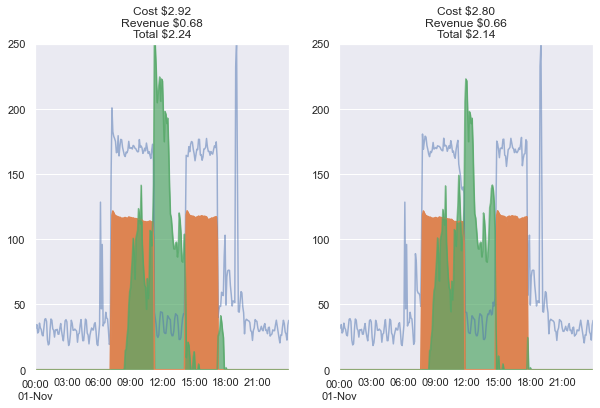

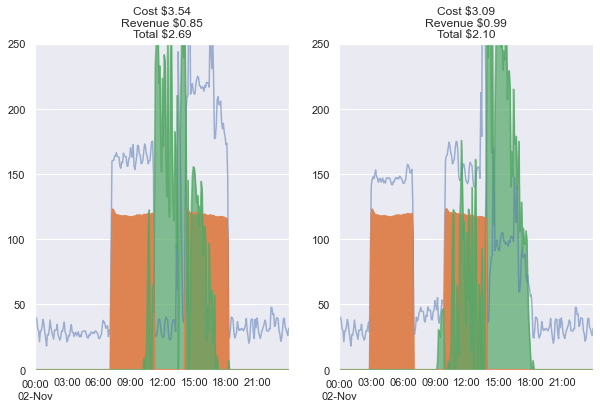

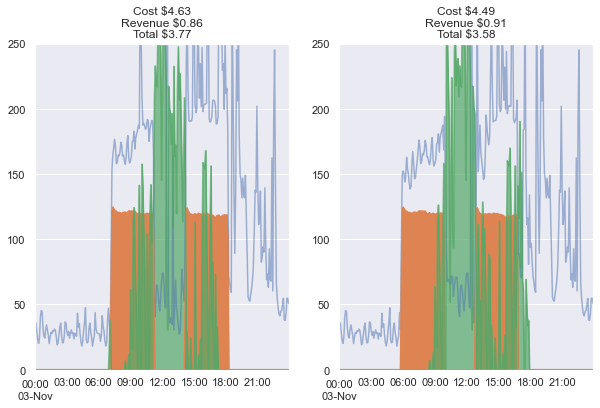

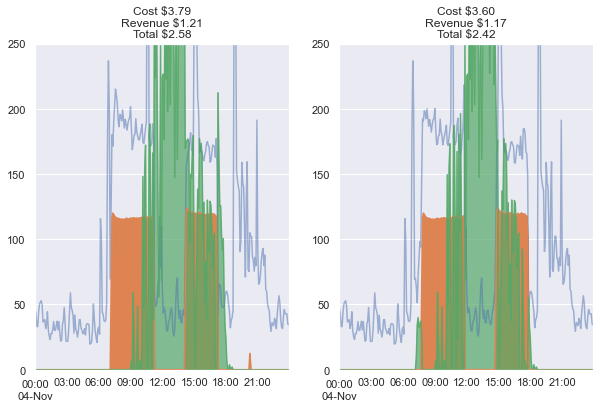

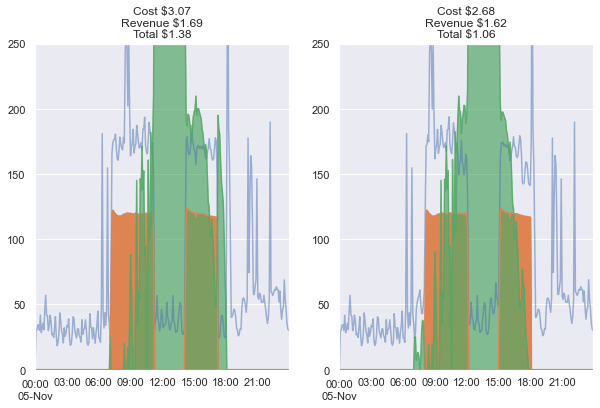

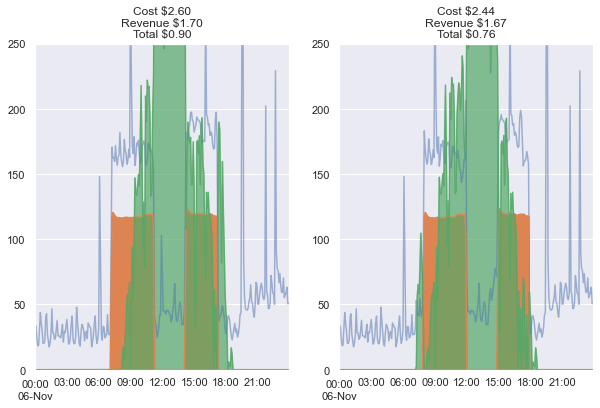

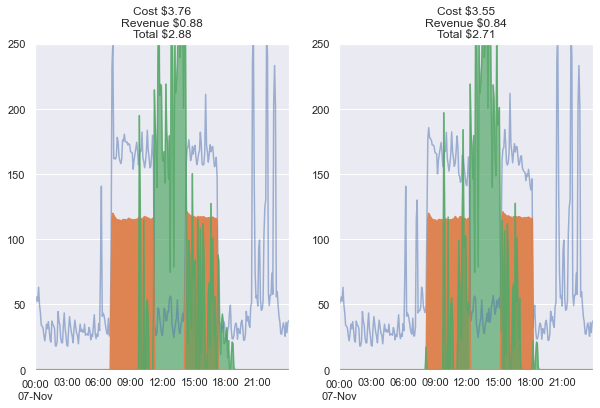

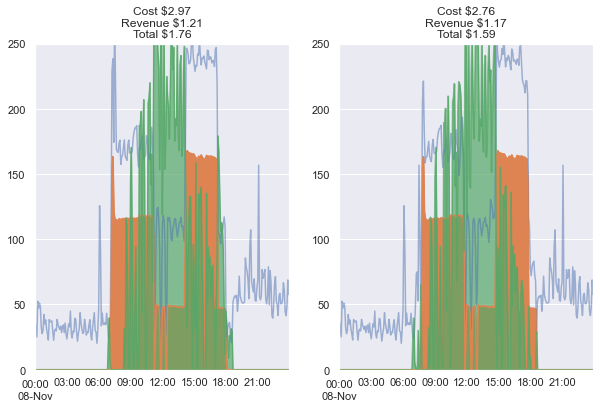

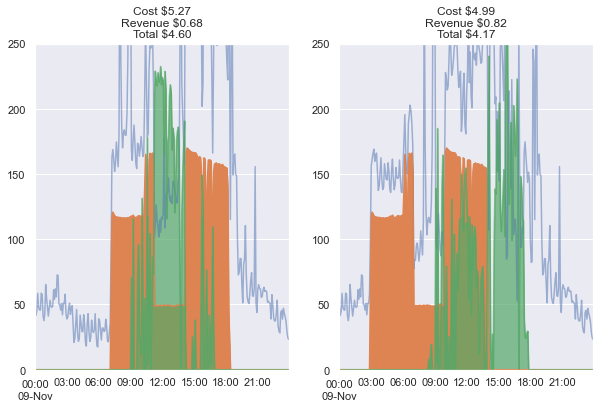

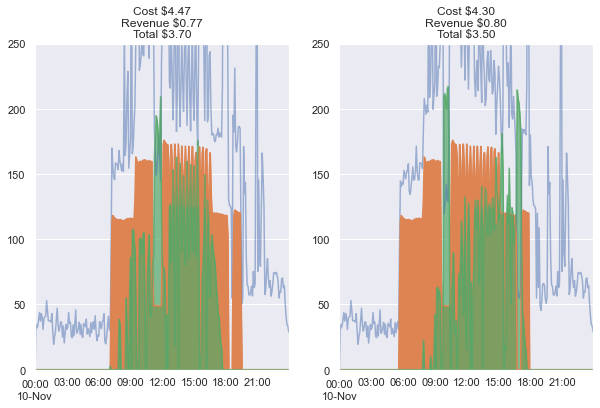

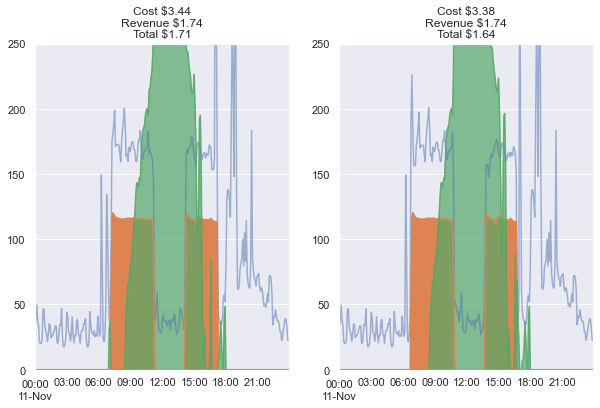

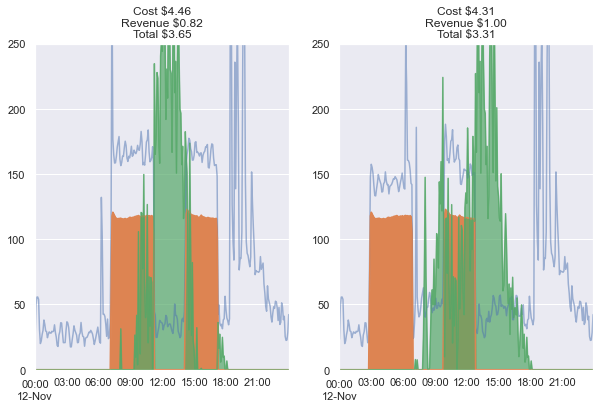

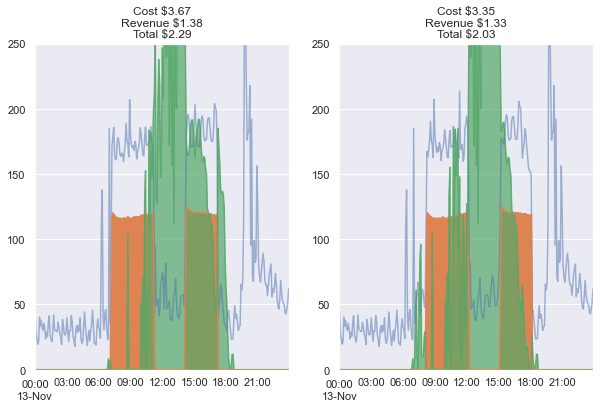

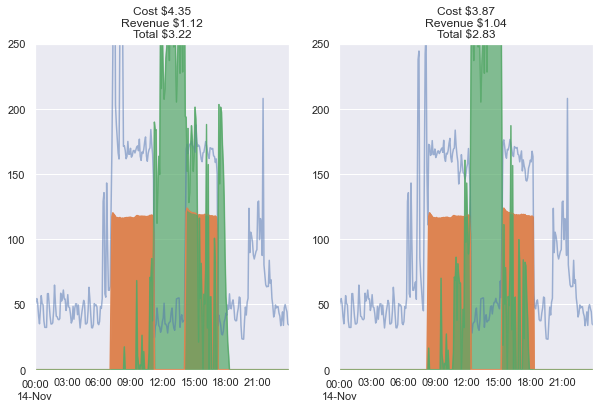

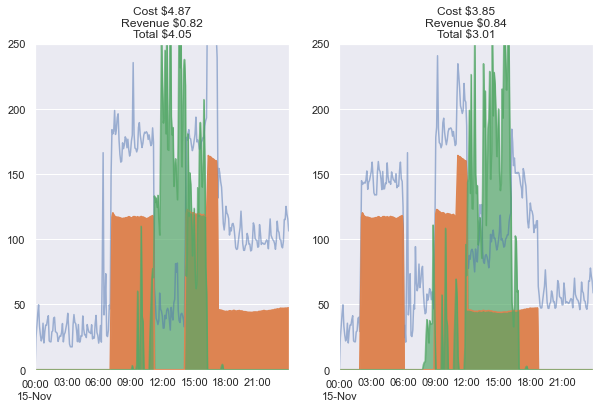

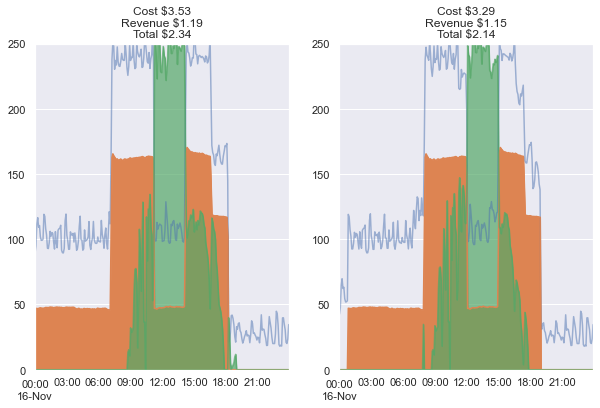

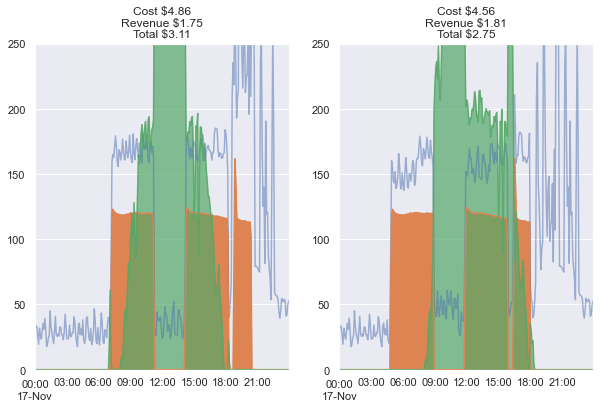

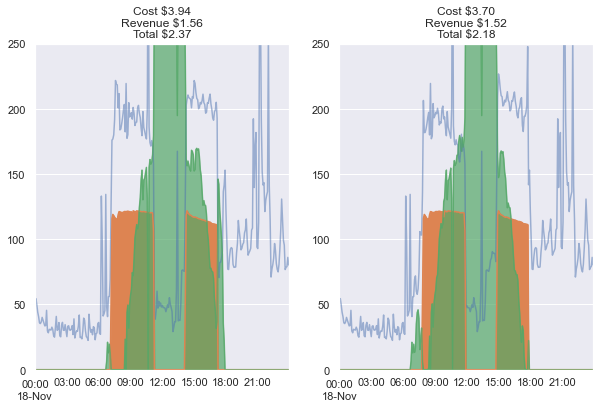

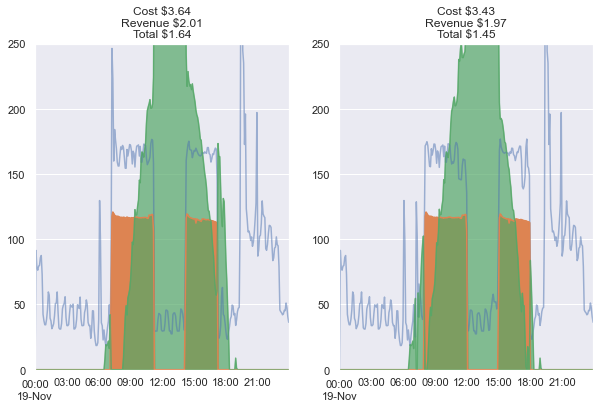

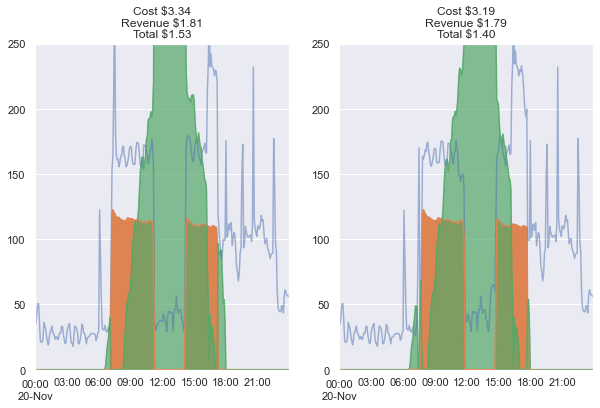

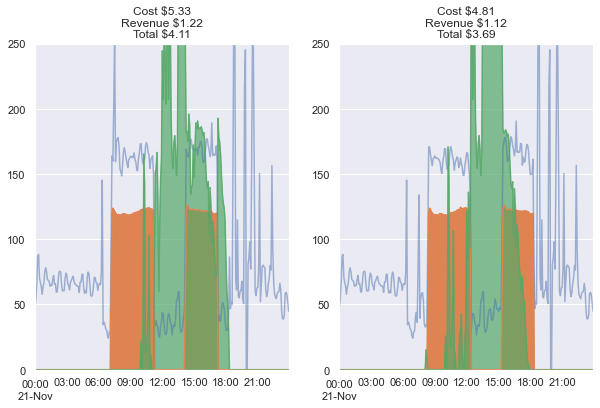

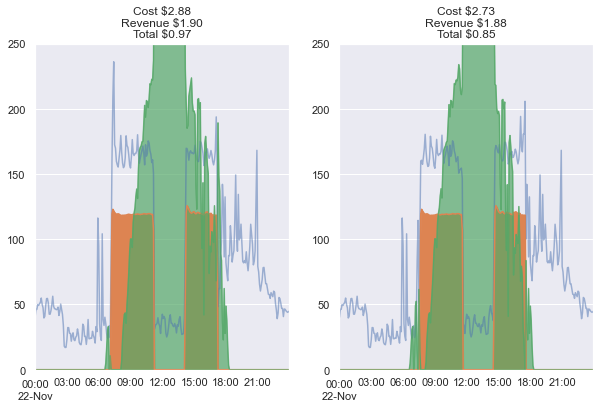

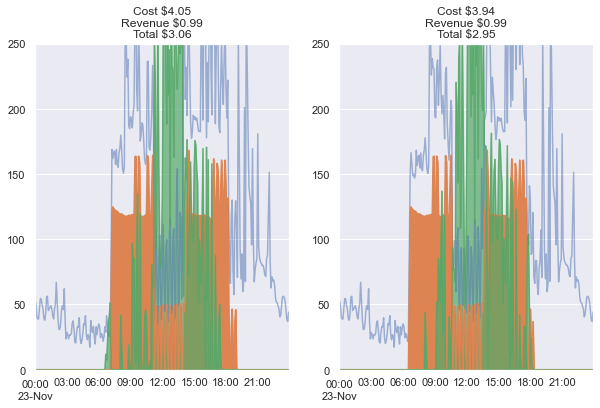

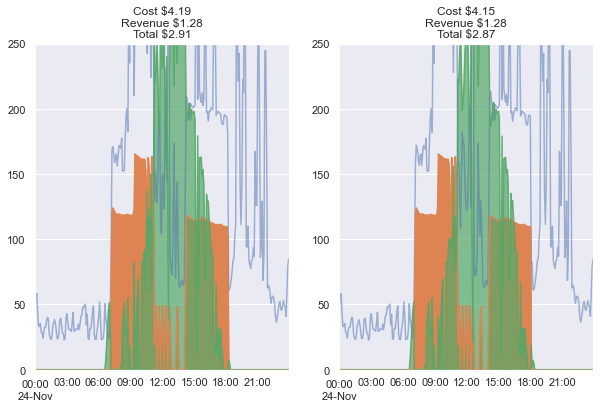

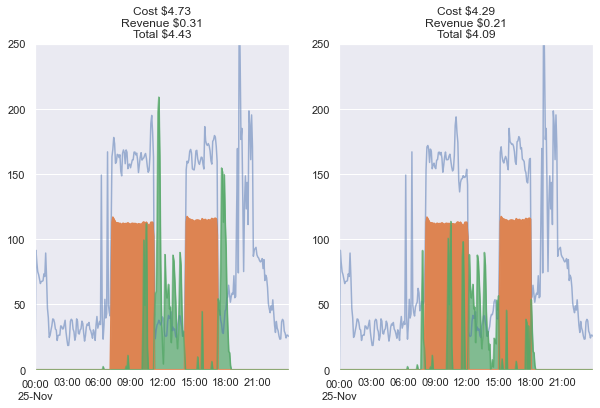

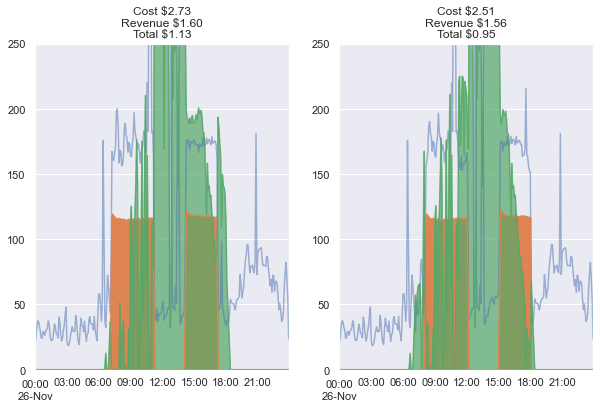

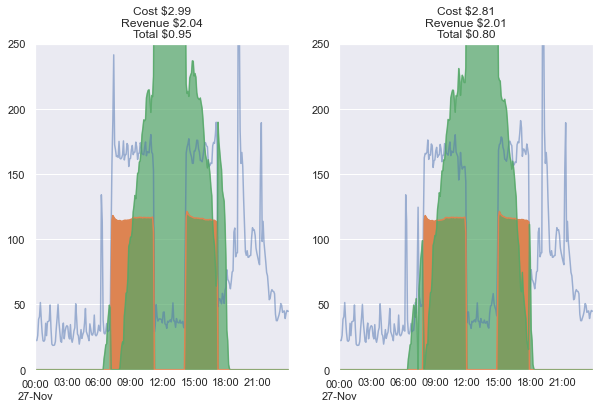

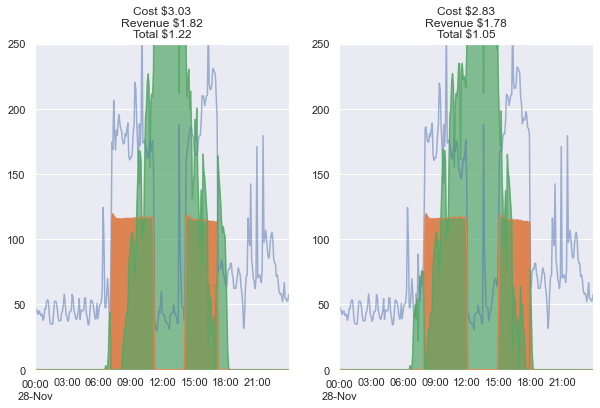

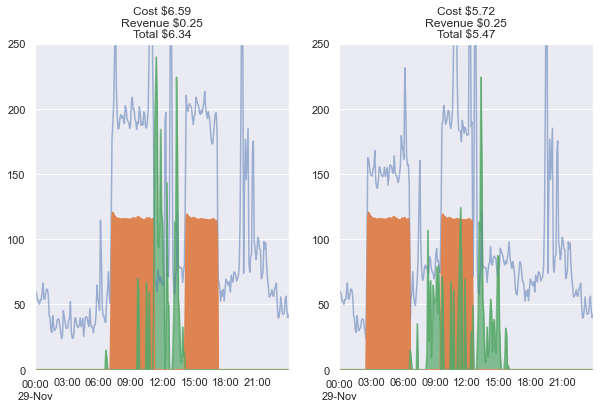

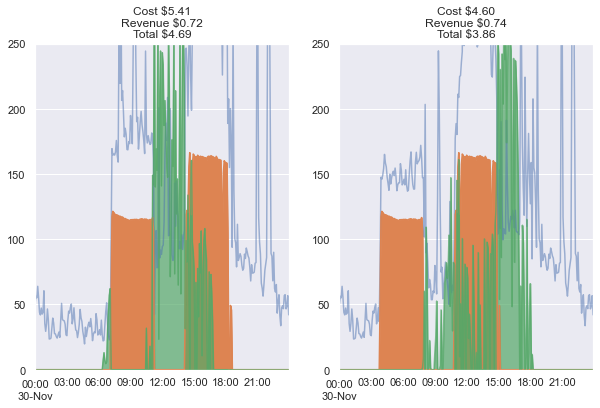

In [9]:
date = '2019-01-30'
days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
for day in days_in_set:
    date = str(day)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    data[date].total_use.plot(ax=ax[0], alpha=0.5)
    data[date].load.clip(lower=0).plot.area(ax=ax[0])
    data[date].grid_export.plot.area(ax=ax[0], alpha=0.7)
    cost = tariff.get_cost(data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[0].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[0].set_ylim([0,250])
    new_data[date].total_use.plot(ax=ax[1], alpha=0.5)
    new_data[date].load.clip(lower=0).plot.area(ax=ax[1])
    new_data[date].grid_export.plot.area(ax=ax[1], alpha=0.7)
    cost = tariff.get_cost(new_data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((new_data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[1].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[1].set_ylim([0,250])
    plt.show()

In [10]:
print('Without Controlling Load')
house_consumption_total = data[date_range].total_use.sum() / 1000
pv_gen_total = data[date_range].PV.sum() / 1000
grid_import_total = data[date_range].grid_import.sum() / 1000
# grid_import_cost_total = data['2019-01'].grid
grid_export_total = data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(data[date_range][['grid_import', 'load']] / 1000)
revenue = data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")


Without Controlling Load
House Usage Total		868.03kWh
Import total			337.04kWh
Export total			460.53kWh
Import Cost			$119.07
Export Revenue Cost		$36.84
Net				$82.22

PV total			991.52kWh


In [11]:
print('With Controlling Load')
house_consumption_total = new_data[date_range].total_use.sum() / 1000
pv_gen_total = new_data[date_range].PV.sum() / 1000
grid_import_total = new_data[date_range].grid_import.sum() / 1000
grid_export_total = new_data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(new_data[date_range][['grid_import', 'load']] / 1000)
revenue = new_data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")

With Controlling Load
House Usage Total		865.46kWh
Import total			332.39kWh
Export total			458.44kWh
Import Cost			$110.01
Export Revenue Cost		$36.68
Net				$73.34

PV total			991.52kWh
